# Visualize data

This notebook will try to perform a visual inspection in order to validate the data generated by our VAE simulation.

1. We compare the distribution of our simulated and original data and we observe that we are getting a similar distribution between the two dataset, which is a good sanity check.  We are producing data that lies in similar regions in the gene expression space.

2. We compare the variance within and between each experiment is preserved after the shift.  If we plot just a handful of experiments we can see that this variation is consistent between the original and simulated data.


In [1]:
%load_ext autoreload
%autoreload 2

import os
import ast
import pandas as pd
import numpy as np
import random
import glob
from plotnine import ggplot, ggtitle, xlab, ylab, geom_point, aes, facet_wrap, scale_color_manual, xlim, ylim, scale_colour_manual 
from sklearn.decomposition import PCA
from keras.models import load_model
import umap

import warnings
warnings.filterwarnings(action='ignore')

from numpy.random import seed
randomState = 123
seed(randomState)

/home/alexandra/anaconda3/envs/batch_effects/lib/python3.5/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
# User parameters
NN_architecture = 'NN_2500_30'
analysis_name = 'analysis_1'

In [3]:
# Load data

# base dir on repo
base_dir = os.path.abspath(os.path.join(os.getcwd(),"../.."))          

# base dir on local machine for data storage
# os.makedirs doesn't recognize `~`
local_dir = os.path.abspath(os.path.join(os.getcwd(), "../../../.."))  
    
latent_dim = NN_architecture.split('_')[-1]

NN_dir = base_dir + "/models/" + NN_architecture

normalized_data_file = os.path.join(
    base_dir,
    "data",
    "input",
    "train_set_normalized.pcl")

model_encoder_file = glob.glob(os.path.join( ## Make more explicit name here
    NN_dir,
    "tybalt_2layer_{}latent_encoder_model.h5".format(latent_dim)))[0]

weights_encoder_file = glob.glob(os.path.join(
    NN_dir,
    "tybalt_2layer_{}latent_encoder_weights.h5".format(latent_dim)))[0]

model_decoder_file = glob.glob(os.path.join(
    NN_dir,
    "tybalt_2layer_{}latent_decoder_model.h5".format(latent_dim)))[0]

weights_decoder_file = glob.glob(os.path.join(
    NN_dir,
    "tybalt_2layer_{}latent_decoder_weights.h5".format(latent_dim)))[0]

simulated_data_file = os.path.join(
    local_dir,
    "Data",
    "Batch_effects",
    "simulated",
    analysis_name,
    "simulated_data.txt.xz")

permuted_simulated_data_file = os.path.join(
    local_dir,
    "Data",
    "Batch_effects",
    "simulated",
    analysis_name,
    "permuted_simulated_data.txt.xz")

## Load data

In [4]:
# Load saved models
loaded_model = load_model(model_encoder_file)
loaded_decode_model = load_model(model_decoder_file)

loaded_model.load_weights(weights_encoder_file)
loaded_decode_model.load_weights(weights_decoder_file)

In [5]:
# Read data
normalized_data = pd.read_table(
    normalized_data_file,
    header=0,
    sep='\t',
    index_col=0).T

simulated_data = pd.read_table(
    simulated_data_file,
    header=0,
    sep='\t',
    index_col=0)

print(normalized_data.shape)
print(simulated_data.shape)

(950, 5549)
(765, 5550)


In [6]:
normalized_data.head(10)

Gene_symbol,PA0001,PA0002,PA0003,PA0004,PA0005,PA0006,PA0007,PA0008,PA0009,PA0010,...,PA5561,PA5562,PA5563,PA5564,PA5565,PA5566,PA5567,PA5568,PA5569,PA5570
05_PA14000-4-2_5-10-07_S2.CEL,0.853357,0.725280,0.640617,0.811465,0.694460,0.533958,0.158865,0.889579,0.884945,0.176558,...,0.466871,0.702785,0.790965,0.893249,0.789939,0.164157,0.970470,0.887472,0.900484,0.880012
54375-4-05.CEL,0.778790,0.767873,0.614859,0.907865,0.398800,0.460849,0.113876,0.761351,0.801740,0.222709,...,0.352020,0.694387,0.733186,0.639074,0.681204,0.110301,0.619554,0.747656,0.749893,0.805374
AKGlu_plus_nt_7-8-09_s1.CEL,0.789155,0.729508,0.725913,0.718989,0.530160,0.466327,0.079507,0.731643,0.827707,0.241847,...,0.392405,0.700352,0.773422,0.791118,0.931585,0.172570,0.797148,0.753785,0.856253,0.811099
anaerobic_NO3_1.CEL,0.716320,0.585079,0.390211,0.193248,0.279456,0.301781,0.513547,0.342051,0.415668,0.125914,...,0.398308,0.419574,0.593955,0.527203,0.706524,0.205510,0.504767,0.105662,0.363409,0.544780
anaerobic_NO3_2.CEL,0.658015,0.592172,0.410331,0.245504,0.312028,0.305852,0.513499,0.336723,0.334226,0.162965,...,0.407801,0.478697,0.571460,0.473054,0.669643,0.155548,0.562927,0.049738,0.388931,0.548814
control1aerobic_Pae_G1a.CEL,0.365512,0.572967,0.417762,0.663096,0.424846,0.606590,0.378900,0.224257,0.161582,0.074461,...,0.491161,0.565151,0.595824,0.382989,0.352268,0.250905,0.362161,0.487777,0.729434,0.483384
control1_anaerobic_Pae_G1a.CEL,0.689254,0.723461,0.510094,0.801569,0.619374,0.937262,0.138600,0.298615,0.306533,0.032482,...,0.754845,0.711126,0.589279,0.542699,0.591066,0.421389,0.392671,0.686055,0.911163,0.585208
control2aerobic_Pae_G1a.CEL,0.353000,0.580626,0.302544,0.639624,0.281793,0.687343,0.462645,0.000000,0.107961,0.093163,...,0.466139,0.545104,0.487957,0.330583,0.419139,0.328478,0.298493,0.254059,0.588305,0.406311
control2_anaerobic_Pae_G1a.CEL,0.674305,0.680740,0.515478,0.747121,0.656701,0.910654,0.149744,0.262492,0.263528,0.019910,...,0.775338,0.653142,0.642205,0.550935,0.565532,0.458622,0.426767,0.701314,0.886074,0.556363
control3aerobic_Pae_G1a.CEL,0.399186,0.653977,0.328755,0.692895,0.482482,0.618446,0.308135,0.191401,0.201170,0.020375,...,0.560889,0.654797,0.493961,0.454766,0.464733,0.456465,0.348577,0.503229,0.718768,0.474649


In [7]:
simulated_data.head(10)

,PA0001,PA0002,PA0003,PA0004,PA0005,PA0006,PA0007,PA0008,PA0009,PA0010,...,PA5562,PA5563,PA5564,PA5565,PA5566,PA5567,PA5568,PA5569,PA5570,experiment_id
GSM199982.CEL,0.646,0.706,0.399,0.642,0.419,0.292,0.424,0.468,0.454,0.496,...,0.535,0.604,0.489,0.526,0.263,0.378,0.444,0.572,0.655,E-GEOD-8083
GSM199983.CEL,0.648,0.706,0.402,0.644,0.424,0.294,0.417,0.469,0.451,0.495,...,0.540,0.611,0.494,0.529,0.266,0.382,0.448,0.577,0.657,E-GEOD-8083
GSM199984.CEL,0.598,0.670,0.433,0.638,0.443,0.364,0.367,0.447,0.433,0.506,...,0.529,0.601,0.487,0.499,0.330,0.392,0.494,0.587,0.636,E-GEOD-8083
GSM199985.CEL,0.614,0.695,0.455,0.667,0.445,0.357,0.364,0.465,0.458,0.481,...,0.542,0.606,0.498,0.509,0.304,0.400,0.500,0.595,0.645,E-GEOD-8083
GSM199986.CEL,0.606,0.680,0.444,0.652,0.446,0.362,0.364,0.456,0.444,0.494,...,0.536,0.605,0.494,0.504,0.318,0.398,0.498,0.593,0.642,E-GEOD-8083
GSM234928.CEL,0.748,0.660,0.375,0.705,0.471,0.316,0.608,0.555,0.534,0.044,...,0.346,0.523,0.460,0.647,0.062,0.410,0.416,0.673,0.778,E-GEOD-9255
GSM234929.CEL,0.327,0.334,0.183,0.379,0.359,0.478,0.363,0.432,0.389,0.320,...,0.294,0.294,0.387,0.402,0.664,0.782,0.452,0.366,0.345,E-GEOD-9255
GSM242671.CEL,0.466,0.678,0.469,0.777,0.279,0.207,0.606,0.378,0.340,0.523,...,0.317,0.320,0.210,0.096,0.169,0.076,0.224,0.471,0.577,E-GEOD-9592
GSM242676.CEL,0.668,0.842,0.603,0.846,0.558,0.403,0.228,0.518,0.570,0.393,...,0.448,0.433,0.425,0.346,0.098,0.090,0.434,0.693,0.711,E-GEOD-9592
GSM242677.CEL,0.460,0.704,0.475,0.786,0.249,0.194,0.609,0.330,0.302,0.559,...,0.296,0.329,0.182,0.075,0.163,0.091,0.166,0.436,0.561,E-GEOD-9592


In [8]:
# Add labels to original normalized data
sample_ids = list(simulated_data.index)
normalized_data_label = normalized_data.copy()

normalized_data_label['experiment_id'] = 'Not selected'
normalized_data_label.loc[sample_ids, 'experiment_id'] = simulated_data['experiment_id']
normalized_data_label.loc[sample_ids].head(10)

Gene_symbol,PA0001,PA0002,PA0003,PA0004,PA0005,PA0006,PA0007,PA0008,PA0009,PA0010,...,PA5562,PA5563,PA5564,PA5565,PA5566,PA5567,PA5568,PA5569,PA5570,experiment_id
GSM199982.CEL,0.602146,0.619571,0.453851,0.616299,0.296061,0.193150,0.596934,0.423352,0.500333,0.111480,...,0.539570,0.467587,0.334931,0.455701,0.177896,0.399522,0.406659,0.529531,0.408715,E-GEOD-8083
GSM199983.CEL,0.565232,0.634272,0.459963,0.639738,0.266436,0.186819,0.644093,0.492162,0.511104,0.096214,...,0.466569,0.460400,0.342895,0.423208,0.183716,0.282770,0.372407,0.537280,0.450979,E-GEOD-8083
GSM199984.CEL,0.507166,0.679804,0.457609,0.714618,0.335181,0.338886,0.620055,0.540087,0.504405,0.099434,...,0.427427,0.422841,0.376656,0.382098,0.330292,0.356257,0.431447,0.559779,0.437137,E-GEOD-8083
GSM199985.CEL,0.528545,0.669231,0.462730,0.657953,0.305657,0.282472,0.510688,0.547912,0.479165,0.150961,...,0.493364,0.455557,0.353950,0.454050,0.239685,0.379235,0.465572,0.578693,0.444357,E-GEOD-8083
GSM199986.CEL,0.542822,0.704964,0.447164,0.649575,0.267066,0.321489,0.441695,0.509655,0.531696,0.135079,...,0.479000,0.464972,0.378888,0.396418,0.242533,0.331793,0.403608,0.551968,0.456357,E-GEOD-8083
GSM234928.CEL,0.692153,0.678493,0.464473,0.544820,0.255672,0.309519,0.441080,0.604207,0.590428,0.148116,...,0.529796,0.525770,0.486252,0.493961,0.302758,0.618235,0.531589,0.612523,0.472696,E-GEOD-9255
GSM234929.CEL,0.338521,0.391192,0.356925,0.313539,0.290200,0.341533,0.285256,0.542908,0.456011,0.208730,...,0.485724,0.433863,0.468346,0.455013,0.594097,0.807568,0.603085,0.518679,0.194243,E-GEOD-9255
GSM242671.CEL,0.755892,0.648197,0.502636,0.554900,0.556640,0.354468,0.364577,0.648139,0.566521,0.201828,...,0.635168,0.672389,0.748181,0.791053,0.201627,0.604573,0.477774,0.761092,0.722155,E-GEOD-9592
GSM242676.CEL,0.830911,0.706195,0.689752,0.683719,0.546938,0.513061,0.174571,0.698305,0.730771,0.221264,...,0.655534,0.812217,0.888770,0.856452,0.199788,0.708080,0.786179,0.890306,0.828895,E-GEOD-9592
GSM242677.CEL,0.654271,0.620200,0.463837,0.520786,0.375430,0.335021,0.409509,0.543349,0.518161,0.183903,...,0.576781,0.734066,0.745339,0.770596,0.230098,0.581041,0.393519,0.714094,0.707756,E-GEOD-9592


## Visualize simulated data (gene space) projected into UMAP space

In [9]:
# UMAP embedding of original input data

# Get and save model
model = umap.UMAP(random_state=randomState).fit(normalized_data)

input_data_UMAPencoded = model.transform(normalized_data)
input_data_UMAPencoded_df = pd.DataFrame(data=input_data_UMAPencoded,
                                         index=normalized_data.index,
                                         columns=['1','2'])
# Add label
input_data_UMAPencoded_df['experiment_id'] = normalized_data_label['experiment_id']

In [10]:
# UMAP embedding of simulated data

# Drop label column
simulated_data_numeric = simulated_data.drop(['experiment_id'], axis=1)

simulated_data_UMAPencoded = model.transform(simulated_data_numeric)
simulated_data_UMAPencoded_df = pd.DataFrame(data=simulated_data_UMAPencoded,
                                         index=simulated_data.index,
                                         columns=['1','2'])

# Add back label column
simulated_data_UMAPencoded_df['experiment_id'] = simulated_data['experiment_id']

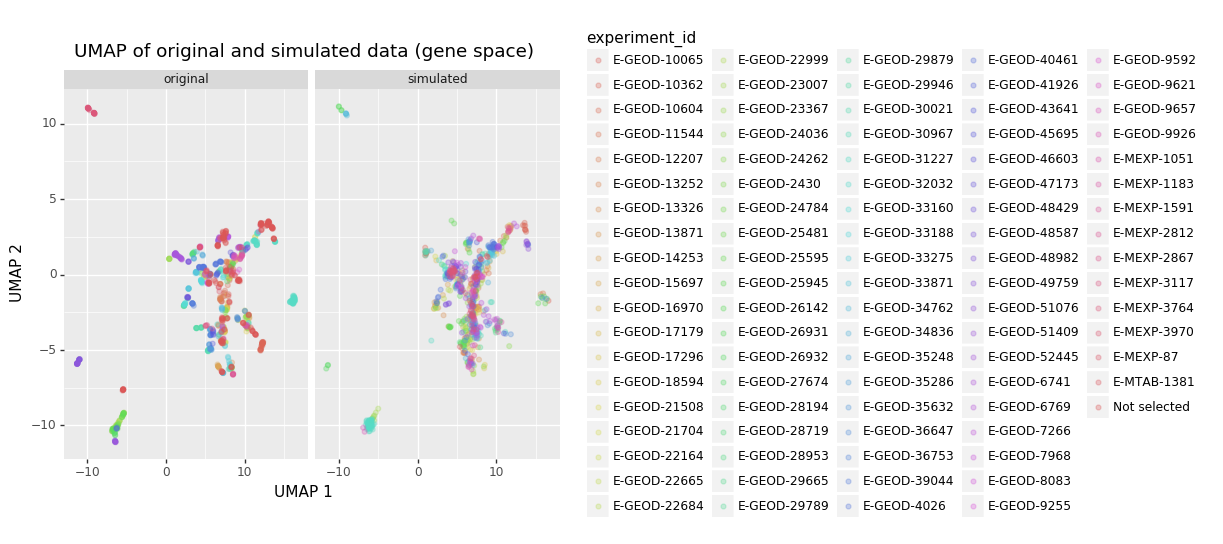

<ggplot: (-9223363263679383755)>

In [11]:
# Add label for input or simulated dataset
input_data_UMAPencoded_df['dataset'] = 'original'
simulated_data_UMAPencoded_df['dataset'] = 'simulated'

# Concatenate input and simulated dataframes together
combined_data_df = pd.concat([input_data_UMAPencoded_df, simulated_data_UMAPencoded_df])

# Plot sequentially
#backgrd_data = combined_data_df[combined_data_df['experiment_id'] == 'Not selected']
#select_data = combined_data_df[combined_data_df['experiment_id'] != 'Not selected']

# Plot
ggplot(combined_data_df, aes(x='1', y='2')) \
+ geom_point(aes(color='experiment_id'), alpha=0.3) \
+ facet_wrap('~dataset') \
+ xlab('UMAP 1') \
+ ylab('UMAP 2') \
+ ggtitle('UMAP of original and simulated data (gene space)')
#+ xlim(3,12) \
#+ ylim(-7,10) \
#+ scale_colour_manual(values=["blue", "purple", "orange", "red", "magenta", "lightgrey"]) \

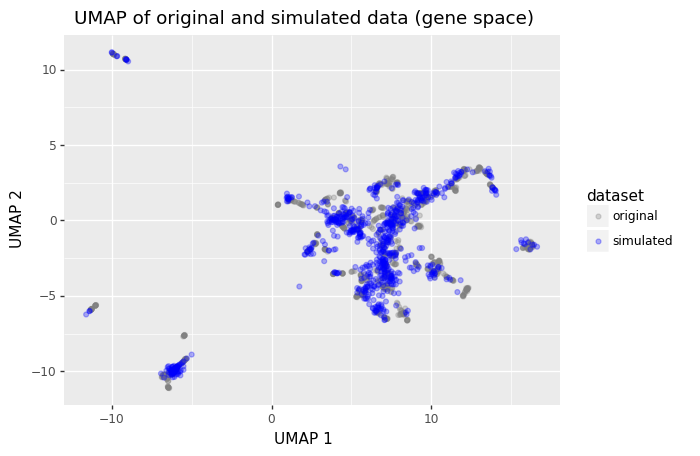

<ggplot: (8773189126825)>

In [12]:
# Overlay original and simulated data 
ggplot(combined_data_df, aes(x='1', y='2')) \
+ geom_point(aes(color='dataset'), alpha=0.3) \
+ scale_colour_manual(values=["grey", "blue"]) \
+ xlab('UMAP 1') \
+ ylab('UMAP 2') \
+ ggtitle('UMAP of original and simulated data (gene space)')

## Visualize simulated data (gene space) projected into PCA space

In [13]:
# UMAP embedding of original input data

# Get and save model
pca = PCA(n_components=2)
pca.fit(normalized_data)

input_data_PCAencoded = pca.transform(normalized_data)
input_data_PCAencoded_df = pd.DataFrame(data=input_data_PCAencoded,
                                         index=normalized_data.index,
                                         columns=['1','2'])
# Add label
input_data_PCAencoded_df['experiment_id'] = normalized_data_label['experiment_id']

In [14]:
# UMAP embedding of simulated data

# Drop label column
simulated_data_numeric = simulated_data.drop(['experiment_id'], axis=1)

simulated_data_PCAencoded = pca.transform(simulated_data_numeric)
simulated_data_PCAencoded_df = pd.DataFrame(data=simulated_data_PCAencoded,
                                         index=simulated_data.index,
                                         columns=['1','2'])

# Add back label column
simulated_data_PCAencoded_df['experiment_id'] = simulated_data['experiment_id']

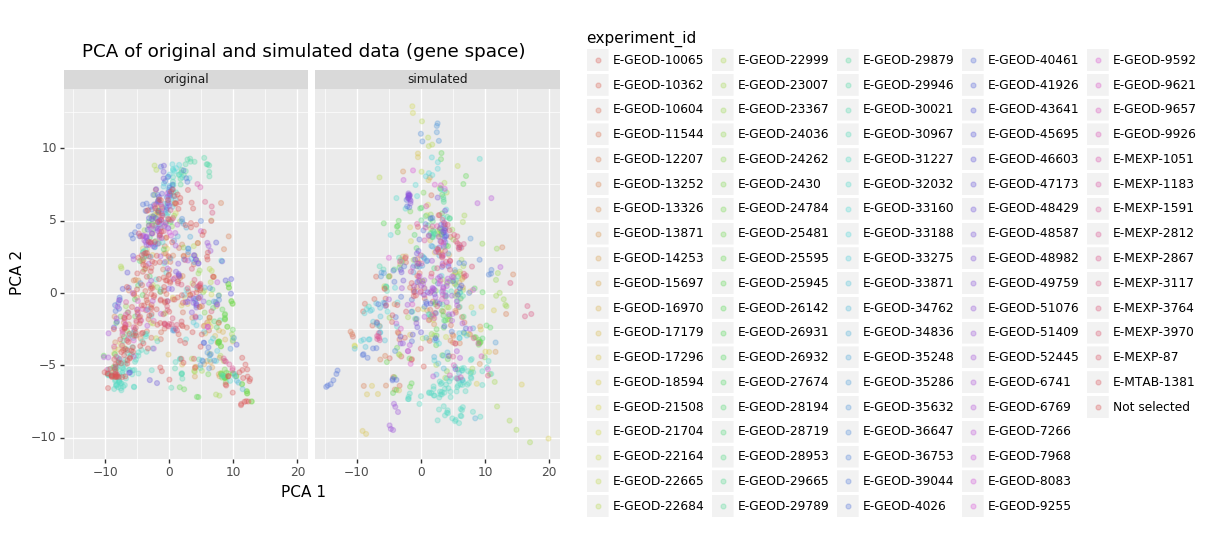

<ggplot: (8773176124217)>

In [15]:
# Add label for input or simulated dataset
input_data_PCAencoded_df['dataset'] = 'original'
simulated_data_PCAencoded_df['dataset'] = 'simulated'

# Concatenate input and simulated dataframes together
combined_data_df = pd.concat([input_data_PCAencoded_df, simulated_data_PCAencoded_df])

# Plot
ggplot(combined_data_df, aes(x='1', y='2')) \
+ geom_point(aes(color='experiment_id'), alpha=0.3) \
+ facet_wrap('~dataset') \
+ xlab('PCA 1') \
+ ylab('PCA 2') \
+ ggtitle('PCA of original and simulated data (gene space)')
#+ scale_colour_manual(values=["blue", "purple", "orange", "red", "magenta", "lightgrey"]) \

## Visualize simulated data (latent space) projected into UMAP space

In [16]:
# Encode original gene expression data into latent space
data_encoded_all = loaded_model.predict_on_batch(normalized_data)
data_encoded_all_df = pd.DataFrame(data_encoded_all, index=normalized_data.index)

data_encoded_all_df.head()

,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
05_PA14000-4-2_5-10-07_S2.CEL,0.422848,0.227143,0.000000,2.775478,0.099096,0.187345,0.0,0.913457,0.563591,5.852476,...,0.0,1.146069,1.128008,0.701732,0.302885,0.0,2.231433,5.592579,0.000000,0.000000
54375-4-05.CEL,1.963878,0.041680,0.019930,3.249997,0.618932,0.000000,0.0,0.000000,4.561747,0.075101,...,0.0,0.000000,0.580954,5.656328,1.081226,0.0,2.466176,3.195375,0.000000,0.169168
AKGlu_plus_nt_7-8-09_s1.CEL,0.000000,0.000000,0.661532,0.424172,4.541715,1.975567,0.0,0.000000,0.000000,5.828680,...,0.0,3.462385,0.507580,0.463046,0.000000,0.0,0.017512,2.657393,0.000000,1.626901
anaerobic_NO3_1.CEL,0.405673,1.504278,0.767638,0.322747,0.000000,7.268587,0.0,0.000000,0.000000,1.062386,...,0.0,1.098558,0.114665,0.770498,0.638446,0.0,0.000000,0.000000,0.039404,2.798199
anaerobic_NO3_2.CEL,0.580626,1.145869,1.115794,0.248105,0.000000,7.246096,0.0,0.000000,0.000000,1.582029,...,0.0,1.120361,0.000000,0.941950,0.694830,0.0,0.000000,0.000000,0.033820,2.735597


In [17]:
# Get and save model
model = umap.UMAP(random_state=randomState).fit(data_encoded_all_df)

input_data_UMAPencoded = model.transform(data_encoded_all_df)
input_data_UMAPencoded_df = pd.DataFrame(data=input_data_UMAPencoded,
                                         index=data_encoded_all_df.index,
                                         columns=['1','2'])
# Add label
input_data_UMAPencoded_df['experiment_id'] = normalized_data_label['experiment_id']

In [18]:
# Encode simulated gene expression data into latent space
simulated_data_numeric = simulated_data.drop(['experiment_id'], axis=1)

simulated_data_encoded = loaded_model.predict_on_batch(simulated_data_numeric)
simulated_data_encoded_df = pd.DataFrame(simulated_data_encoded, index=simulated_data.index)

simulated_data_encoded_df.head()

,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
GSM199982.CEL,0.282942,1.423691,2.200658,0.000000,0.000000,4.004060,0.0,0.0,0.0,2.480138,...,0.604215,0.461797,1.007273,0.554873,0.613069,0.622261,0.000000,0.0,1.714199,1.343297
GSM199983.CEL,0.239269,1.397290,2.273486,0.000000,0.000000,3.962496,0.0,0.0,0.0,2.647557,...,0.586466,0.485276,1.029876,0.585810,0.551782,0.641299,0.000000,0.0,1.743271,1.345463
GSM199984.CEL,0.209467,0.988909,2.272176,0.054070,0.041561,1.034924,0.0,0.0,0.0,2.722865,...,0.539365,1.222701,1.575825,0.851276,0.195984,1.827978,0.240145,0.0,2.741134,1.255550
GSM199985.CEL,0.382011,0.760073,2.112994,0.151017,0.000000,1.459898,0.0,0.0,0.0,2.811465,...,0.451489,0.966999,1.223545,1.174969,0.502785,1.306382,0.211409,0.0,2.287431,1.128524
GSM199986.CEL,0.263312,0.858536,2.259657,0.081945,0.021163,1.245317,0.0,0.0,0.0,2.827909,...,0.486302,1.112467,1.447823,1.013134,0.322354,1.591654,0.221455,0.0,2.531366,1.192407


In [19]:
# Use same UMAP projection to plot simulated data
simulated_data_UMAPencoded = model.transform(simulated_data_encoded_df)
simulated_data_UMAPencoded_df = pd.DataFrame(data=simulated_data_UMAPencoded,
                                         index=simulated_data.index,
                                         columns=['1','2'])

# Add back label column
simulated_data_UMAPencoded_df['experiment_id'] = simulated_data['experiment_id']

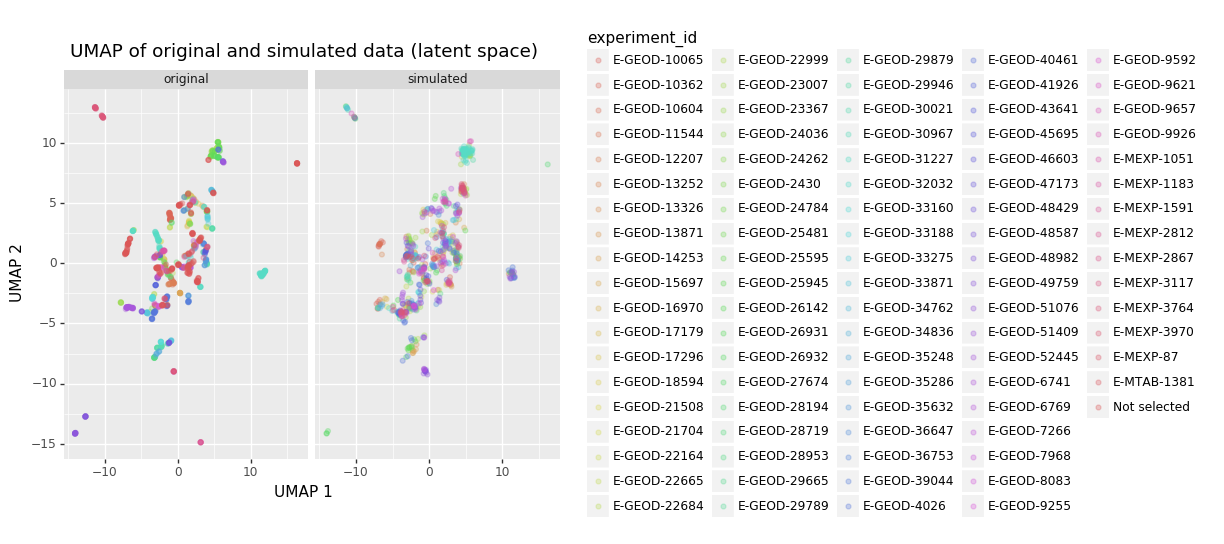

<ggplot: (-9223363263606529518)>

In [20]:
# Add label for input or simulated dataset
input_data_UMAPencoded_df['dataset'] = 'original'
simulated_data_UMAPencoded_df['dataset'] = 'simulated'

# Concatenate input and simulated dataframes together
combined_data_df = pd.concat([input_data_UMAPencoded_df, simulated_data_UMAPencoded_df])

# Plot
ggplot(combined_data_df, aes(x='1', y='2')) \
+ geom_point(aes(color='experiment_id'), alpha=0.3) \
+ facet_wrap('~dataset') \
+ xlab('UMAP 1') \
+ ylab('UMAP 2') \
+ ggtitle('UMAP of original and simulated data (latent space)')
#+ xlim(-10,5) \
#+ ylim(-10,10) \
#+ scale_colour_manual(values=["blue", "purple", "orange", "red", "magenta", "lightgrey"]) \

## Visualize simulated data (latent space) projected into PCA space

In [21]:
# Get and save model
pca = PCA(n_components=2)
pca.fit(data_encoded_all_df)

input_data_PCAencoded = pca.transform(data_encoded_all_df)
input_data_PCAencoded_df = pd.DataFrame(data=input_data_PCAencoded,
                                         index=data_encoded_all_df.index,
                                         columns=['1','2'])
# Add label
input_data_PCAencoded_df['experiment_id'] = normalized_data_label['experiment_id']

In [22]:
# Use same UMAP projection to plot simulated data
simulated_data_PCAencoded = pca.transform(simulated_data_encoded_df)
simulated_data_PCAencoded_df = pd.DataFrame(data=simulated_data_PCAencoded,
                                         index=simulated_data.index,
                                         columns=['1','2'])

# Add back label column
simulated_data_PCAencoded_df['experiment_id'] = simulated_data['experiment_id']

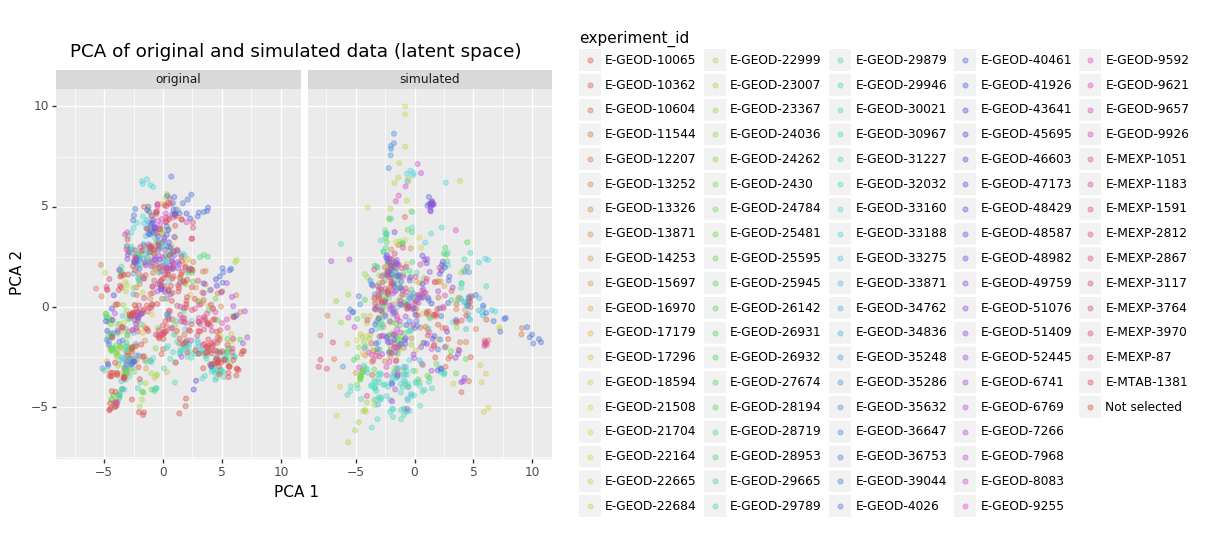

<ggplot: (8773248238193)>

In [23]:
# Add label for input or simulated dataset
input_data_PCAencoded_df['dataset'] = 'original'
simulated_data_PCAencoded_df['dataset'] = 'simulated'

# Concatenate input and simulated dataframes together
combined_data_df = pd.concat([input_data_PCAencoded_df, simulated_data_PCAencoded_df])

# Plot
ggplot(combined_data_df, aes(x='1', y='2')) \
+ geom_point(aes(color='experiment_id'), alpha=0.4) \
+ facet_wrap('~dataset') \
+ xlab('PCA 1') \
+ ylab('PCA 2') \
+ ggtitle('PCA of original and simulated data (latent space)')
#+ scale_colour_manual(values=["blue", "purple", "orange", "red", "magenta", "lightgrey"]) \